In [1]:
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
nltk.download('wordnet')
import pickle
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

review_data = load_files(r"/content/drive/My Drive/assignment11/movie_review")
X, y = review_data.data, review_data.target

documents = []

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 

    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)  
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()

tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
X_train = X_train.T
X_test = X_test.T


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
from tqdm import tqdm_notebook

  Using cached https://github.com/chengs/tqdm/archive/colab.zip
  Created wheel for tqdm: filename=tqdm-4.28.1-py2.py3-none-any.whl size=47867 sha256=c31a934a7edffca728f90293716b9909bf7b7f6e4b17c04635670120e5829095
  Stored in directory: /tmp/pip-ephem-wheel-cache-ie7ookhi/wheels/41/18/ee/d5dd158441b27965855b1bbae03fa2d8a91fe645c01b419896
Successfully built tqdm
ERROR: spacy 2.2.4 has requirement tqdm<5.0.0,>=4.38.0, but you'll have tqdm 4.28.1 which is incompatible.
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [0]:
def sigmoid(z):
    return 1/(1 + np.exp(-1*z))

# derivation of sigmoid
def dsigmoid(z):
    t = sigmoid(z)
    return t*(1-t)

def classification(x, u, v, w, b_u, b_v, b_w):
    y_ = np.dot(u, x) + b_u
    y = sigmoid(y_)
    z_ = np.dot(v, y) + b_v
    z = sigmoid(z_)
    h_ = np.dot(w, z) + b_w
    h = sigmoid(h_)
    
    return y_, y, z_, z, h_, h
  
    
def j(h, label, m):
    tmp = (-1*label*np.log(h)) - ((1-label)*np.log(1-h))
    total = np.sum(tmp)
    return total/m

def dsigmoid(z):
    t = sigmoid(z)
    return t*(1-t)


def descending(x_, y_, y, z_, z, h_, h , u, v, w, label):
    dj_dh = (-1*label/(h)) + ((1-label)/(1-h)) 
    dh_dh = dsigmoid(h_)
    dh_dw = z
    tmp0 = dj_dh * dh_dh
    dw = np.dot(tmp0, dh_dw.T)
    db_w = np.sum(dw, axis=1)
    
    tmp1 = np.dot(w.T, tmp0)
    tmp2 = tmp1 * dsigmoid(z_)
    dv = np.dot(tmp2, y.T)
    db_v = np.sum(dv, axis = 1)
    
    tmp3= np.dot(v.T, tmp2)
    tmp4 = tmp3 * dsigmoid(y_)
    du = np.dot(tmp4, x_.T)
    db_u = np.sum(du, axis=1)
    
    return dw, dv, du, db_w, db_v, db_u

def casting(y):
    result = []
    for i in y[:][0]:
        if i>=0.5:
            result.append(1)
        else:
            result.append(0)
    return result


In [5]:

train_m = 1401
test_m = 601

lamb = 1.1
step = 0.00005

# # weight
u = np.random.randn(255, 1500)
v = np.random.randn(64, 255)
w = np.random.randn(1, 64)

# u = np.random.normal(0, 0.1, (255, 1500))
# v = np.random.normal(0, 0.1, (64, 255))
# w = np.random.normal(0, 0.1, (1, 64))

train_loss_list = []
test_loss_list = []
count_iter = []
train_accuracy = []
test_accuracy = []  
# # bias
# b_u = np.random.randn(155,1)
# b_v = np.random.randn(34,1)
# b_w = np.random.randn(1,1)
b_u = np.random.normal(0, 0.1, (255,1))
b_v = np.random.normal(0, 0.1, (64,1))
b_w = np.random.normal(0, 0.1, (1,1))

total_param = 255 + 64 + 1
enough = False
count = 0

for a in tqdm_notebook(range(10000),desc = 'count'):
    
    y_, y, z_, z, h_, y_pred_train = classification(X_train, u, v, w, b_u, b_v, b_w)  
    f_y_, f_y, f_z_, f_z, f_h_, y_pred_test = classification(X_test, u, v, w, b_u, b_v, b_w)
    train_loss  = j(y_pred_train, y_train, train_m)
    test_loss = j(y_pred_test, y_test, test_m)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    count_iter.append(count)
    
    dw, dv, du, db_w, db_v, db_u = descending(X_train, y_, y, z_, z, h_, y_pred_train , u, v, w, y_train)
    
    
    w = w*(1-(step*lamb)/total_param) - step*dw
    v = v*(1-(step*lamb)/total_param) - step*dv
    u = u*(1-(step*lamb)/total_param) - step*du
        
    b_w = b_w*(1-(step*lamb)/total_param) - step*db_w[:,None]
    b_v = b_v*(1-(step*lamb)/total_param) - step*db_v[:,None]
    b_u = b_u*(1-(step*lamb)/total_param) - step*db_u[:,None]
    
    ac_y_train = casting(y_pred_train)
    ac_y_test = casting(y_pred_test)
    train_accuracy.append(accuracy_score(y_train, ac_y_train))
    test_accuracy.append(accuracy_score(y_test,ac_y_test))

    count += 1
#     print(confusion_matrix(y_train,ac_y_train))
#     print(classification_report(y_train,ac_y_train))  
#     print(accuracy_score(y_train, ac_y_train))
    # if count >= 20000 :
    #     enough = True




/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm_notebook.py:88: TqdmExperimentalWarning: Detect Google Colab 0.0.1a2 and thus load dummy ipywidgets package. Note that UI is different from that in Jupyter. See https://github.com/tqdm/tqdm/pull/640
  " See https://github.com/tqdm/tqdm/pull/640".format(colab.__version__), TqdmExperimentalWarning)


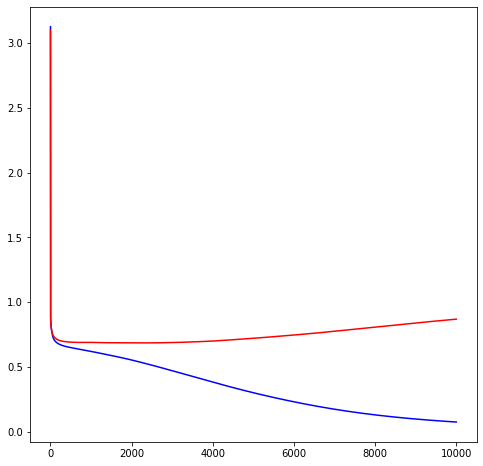

In [8]:
plt.figure(figsize=(8, 8))
plt.plot(count_iter, train_loss_list,  color='b' )
plt.plot(count_iter, test_loss_list,  color='r' )
plt.show()

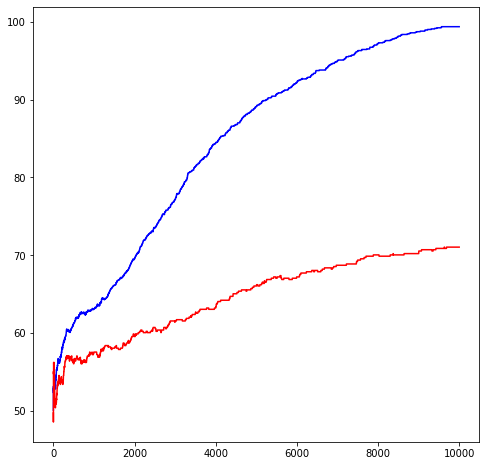

71.04825291181365
99.3576017130621


In [9]:
ac_train = np.array(train_accuracy)*100
ac_test = np.array(test_accuracy)*100

plt.figure(figsize=(8, 8))
plt.plot(count_iter, ac_train,  color='b' ) 
plt.plot(count_iter, ac_test,  color='r' )
plt.show()
print(ac_test[-1])
print(ac_train[-1])

In [0]:
_